In [1]:
suppressPackageStartupMessages(require(tidyverse))
suppressPackageStartupMessages(require(data.table))


In [2]:
meta_sumstats_f    <- '/oak/stanford/groups/mrivas/projects/biomarkers/meta/plink_imputed/filtered/GLOBAL_Alanine_aminotransferase.sumstats.tsv.gz '
meta_flipfixed_f   <- '/oak/stanford/groups/mrivas/projects/biomarkers/meta/plink_imputed/filtered_flipfixed/GLOBAL_Alanine_aminotransferase.sumstats.tsv'
meta_flipfixed_img <- '/oak/stanford/groups/mrivas/projects/biomarkers/meta/plink_imputed/filtered_flipfixed/GLOBAL_Alanine_aminotransferase.check.png'
gwas_f             <- '/oak/stanford/groups/mrivas/projects/biomarkers/sumstats_diverse/white_british/plink_imputed/filtered/INT_Alanine_aminotransferase_all.glm.linear.filtered.maf001.info03.tsv.gz'
pvar_f             <- '/oak/stanford/groups/mrivas/users/ytanigaw/repos/rivas-lab/public-resources/uk_biobank/biomarkers/meta_flipfix/imp_ref_alt_check/ukb_imp_v3.mac1.flipcheck.tsv.gz'


In [ ]:
pvar_df <- fread(cmd=paste0('zcat ', pvar_f)) %>% 
mutate(FASTA_ALT = if_else(toupper(REF) == toupper(FASTA_REF), ALT, REF)) %>%
select(-REF, -ALT) %>%
mutate(FASTA_REF = toupper(FASTA_REF), FASTA_ALT = toupper(FASTA_ALT)) %>%
rename('CHROM' = '#CHROM')


In [ ]:
meta_sumstats_df  <- fread(cmd=paste0('zcat ', meta_sumstats_f))
gwas_df <- fread(cmd=paste0('zcat ', gwas_f))


In [7]:
add_flip_annotation <- function(df, pvar_df){
    pvar_df %>% 
    rename('MarkerName' = 'ID') %>%
    right_join(df, by='MarkerName') %>%
    mutate(
        REF_is_FASTA_REF = (toupper(REF) == FASTA_REF),    
        REF_is_FASTA_ALT = (toupper(REF) == FASTA_ALT),
        ALT_is_FASTA_REF = (toupper(ALT) == FASTA_REF),    
        ALT_is_FASTA_ALT = (toupper(ALT) == FASTA_ALT),
        is_not_flipped = (REF_is_FASTA_REF & ALT_is_FASTA_ALT),
        is_flipped     = (REF_is_FASTA_ALT & ALT_is_FASTA_REF)
    )
}

flip_check_plot <- function(df, gwas_df, titlelab, xlab){
    df %>% 
    rename('P' = 'P-value') %>%
    filter(P < 5e-8) %>%
    select(MarkerName, Effect, is_flipped) %>% 
    inner_join(gwas_df %>% select(ID, BETA) %>% rename('MarkerName' = 'ID'), by='MarkerName') %>%
    drop_na() %>%
    ggplot(aes(x=Effect, y=BETA, color=is_flipped)) +
    geom_point(alpha=0.05) + 
    labs(
        title = titlelab,
        x = xlab,
        y = 'BETA from WB GWAS sumstats'
    )+
    guides(colour = guide_legend(override.aes = list(alpha = 1)))    
}


In [30]:
pvar_df %>% dim()

[1] 96587443        5

In [27]:
pvar_df %>% head()

CHROM,POS,ID,FASTA_REF,FASTA_ALT
<chr>,<int>,<chr>,<chr>,<chr>
1,724321,1:724321_TGAGTG_T,TGAGTG,T
1,724324,1:724324_G_A,G,A
1,724330,1:724330_T_C,T,C
1,724360,1:724360_T_G,T,G
1,724365,1:724365_A_G,A,G
1,724389,1:724389_T_C,T,C


In [34]:
joined_df <- pvar_df %>% 
rename('MarkerName' = 'ID') %>%
right_join(meta_sumstats_df, by='MarkerName')


In [32]:
meta_sumstats_df %>% dim()

[1] 9154123      13

In [35]:
joined_df %>% dim()

[1] 9154123      17

In [36]:
joined_df %>% head()

CHROM,POS,MarkerName,FASTA_REF,FASTA_ALT,REF,ALT,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,MAF,MACH_R2
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,158192339,1:158192339_G_A,G,A,G,A,0.0022,0.0029,0.44670,++++,0.0,0.446,3,0.9306,0.2321250,1.000360
3,135839893,3:135839893_C_G,C,G,C,G,0.0077,0.0094,0.41440,+--+,19.1,3.709,3,0.2947,0.0163106,0.968667
6,48990486,6:48990486_C_T,C,T,C,T,0.0011,0.0026,0.66290,++-+,0.0,1.924,3,0.5883,0.3077320,1.000550
6,76678298,6:76678298_C_CT,C,CT,C,CT,0.0069,0.0029,0.01792,+--+,27.2,4.118,3,0.2490,0.2144020,0.990640
21,44403419,21:44403419_GA_G,GA,G,GA,G,0.0050,0.0035,0.14650,+-++,39.7,4.972,3,0.1739,0.1375610,1.000010
7,4277699,7:4277699_T_A,T,A,T,A,-0.0097,0.0105,0.35830,--+?,0.0,1.578,2,0.4543,0.0127087,0.999755


In [37]:
joined_annotated_df  <- joined_df %>%
    mutate(
        REF_is_FASTA_REF = (toupper(REF) == FASTA_REF),    
        REF_is_FASTA_ALT = (toupper(REF) == FASTA_ALT),
        ALT_is_FASTA_REF = (toupper(ALT) == FASTA_REF),    
        ALT_is_FASTA_ALT = (toupper(ALT) == FASTA_ALT),
        is_not_flipped = (REF_is_FASTA_REF & ALT_is_FASTA_ALT),
        is_flipped     = (REF_is_FASTA_ALT & ALT_is_FASTA_REF)
    )

In [39]:
joined_annotated_df %>% count(is_flipped)

is_flipped,n
<lgl>,<int>
FALSE,9154118
NA,5


In [47]:
n_flips <- joined_annotated_df %>% select(is_flipped) %>% drop_na() %>% pull() %>% sum()
print(paste0('The number of allele flips: ', n_flips))


[1] "The number of allele flips: 0"


In [48]:
gwas_df %>% dim()


[1] 16160753       20

In [49]:
gwas_df %>% head()

ID,SNP,TOTAL_MAF,CHROM,POS,REF,ALT1,ALT,A1,AX,A1_CT,ALLELE_CT,A1_FREQ,MACH_R2,TEST,OBS_CT,BETA,SE,T_STAT,P
<chr>,<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
1:10511_G_A,rs534229142,0.00121697,1,10511,G,A,A,A,G,844.35,637636,0.00132419,0.454263,ADD,318818,0.01066690,0.0510984,0.208753,0.834641
1:10616_CCGCCGTTGCAAAGGCGCGCCG_C,1:10616_CCGCCGTTGCAAAGGCGCGCCG_C,0.00583227,1,10616,CCGCCGTTGCAAAGGCGCGCCG,C,C,C,CCGCCGTTGCAAAGGCGCGCCG,633950.00,637636,0.99421900,0.454192,ADD,318818,-0.00874607,0.0245117,-0.356812,0.721233
1:13289_CCT_C,1:13289_CCT_C,0.00384929,1,13289,CCT,C,C,C,CCT,2393.72,637636,0.00375406,0.295486,ADD,318818,0.03797800,0.0376724,1.008110,0.313402
1:13453_T_C,rs568927457,0.00617430,1,13453,T,C,C,C,T,4172.71,637636,0.00654403,0.471957,ADD,318818,-0.02692170,0.0226096,-1.190720,0.233765
1:13483_G_C,rs554760071,0.00511713,1,13483,G,C,C,C,G,3233.33,637636,0.00507080,0.498893,ADD,318818,0.02427570,0.0249651,0.972386,0.330859
1:13494_A_G,rs574697788,0.00337301,1,13494,A,G,G,G,A,2258.20,637636,0.00354152,0.344193,ADD,318818,0.01757700,0.0359333,0.489155,0.624733


In [31]:
gwas_df %>% 
inner_join(pvar_df, by=c('CHROM', 'POS', 'ID')) 

[1] 16160753       20

In [25]:
gwas_df <- fread(cmd=paste0('zcat ', gwas_f))


In [28]:
gwas_df %>% colnames()

[1] "ID"        "SNP"       "TOTAL_MAF" "CHROM"     "POS"       "REF"      
 [7] "ALT1"      "ALT"       "A1"        "AX"        "A1_CT"     "ALLELE_CT"
[13] "A1_FREQ"   "MACH_R2"   "TEST"      "OBS_CT"    "BETA"      "SE"       
[19] "T_STAT"    "P"

In [50]:
joined_annotated_df %>% colnames()

[1] "CHROM"            "POS"              "MarkerName"       "FASTA_REF"       
 [5] "FASTA_ALT"        "REF"              "ALT"              "Effect"          
 [9] "StdErr"           "P-value"          "Direction"        "HetISq"          
[13] "HetChiSq"         "HetDf"            "HetPVal"          "MAF"             
[17] "MACH_R2"          "REF_is_FASTA_REF" "REF_is_FASTA_ALT" "ALT_is_FASTA_REF"
[21] "ALT_is_FASTA_ALT" "is_not_flipped"   "is_flipped"

In [52]:
p <- joined_annotated_df %>% 
    rename('P' = 'P-value') %>%
    filter(P < 5e-8) %>%
    select(MarkerName, Effect, is_flipped) %>% 
    inner_join(gwas_df %>% select(ID, BETA) %>% rename('MarkerName' = 'ID'), by='MarkerName') %>%
    drop_na() %>%
    ggplot(aes(x=Effect, y=BETA, color=is_flipped)) +
    geom_point(alpha=0.05) + 
#     labs(
#         title = titlelab,
#         x = xlab,
#         y = 'BETA from WB GWAS sumstats'
#     )+
    guides(colour = guide_legend(override.aes = list(alpha = 1)))    


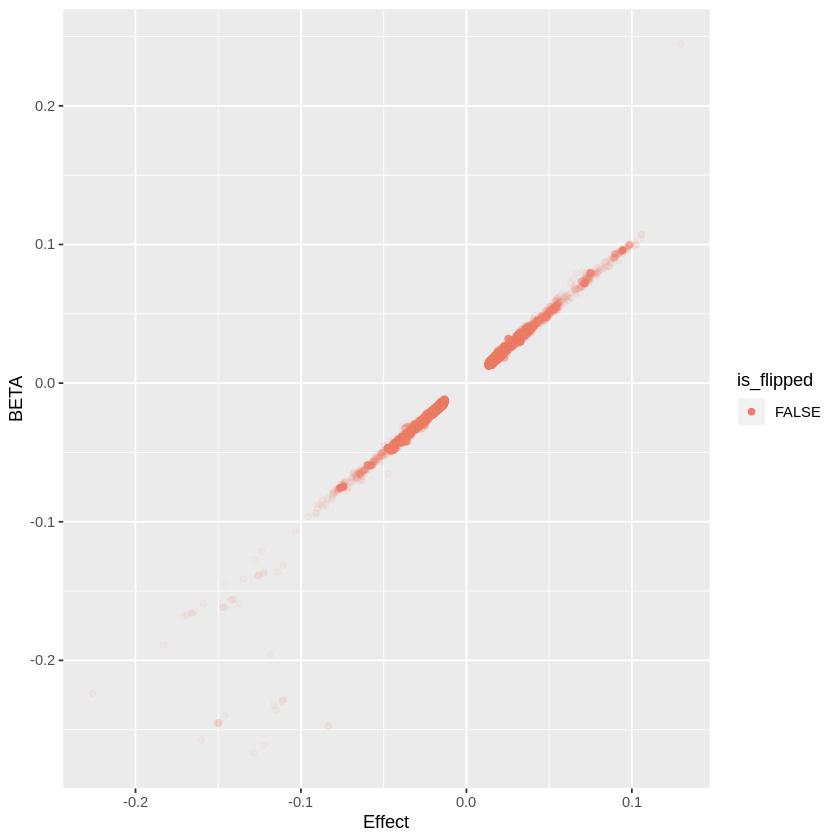

In [53]:
p

In [23]:
pvar_df %>% head()

CHROM,POS,ID,FASTA_REF,FASTA_ALT
<chr>,<int>,<chr>,<chr>,<chr>
1,724321,1:724321_TGAGTG_T,TGAGTG,T
1,724324,1:724324_G_A,G,A
1,724330,1:724330_T_C,T,C
1,724360,1:724360_T_G,T,G
1,724365,1:724365_A_G,A,G
1,724389,1:724389_T_C,T,C


In [22]:
meta_sumstats_df  <- fread(cmd=paste0('zcat ', meta_sumstats_f))


In [20]:
pvar_df %>% 
rename('MarkerName' = 'ID') %>%
left_join(meta_sumstats_df, by='MarkerName') %>%
# mutate(
#     REF_is_FASTA_REF = (toupper(REF) == FASTA_REF),    
#     REF_is_FASTA_ALT = (toupper(REF) == FASTA_ALT),
#     ALT_is_FASTA_REF = (toupper(ALT) == FASTA_REF),    
#     ALT_is_FASTA_ALT = (toupper(ALT) == FASTA_ALT),
#     is_not_flipped = (REF_is_FASTA_REF & ALT_is_FASTA_ALT),
#     is_flipped     = (REF_is_FASTA_ALT & ALT_is_FASTA_REF)
# ) %>% 
head()


CHROM,POS,MarkerName,FASTA_REF,FASTA_ALT,REF,ALT,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,MAF,MACH_R2
<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,724321,1:724321_TGAGTG_T,TGAGTG,T,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,724324,1:724324_G_A,G,A,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,724330,1:724330_T_C,T,C,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,724360,1:724360_T_G,T,G,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,724365,1:724365_A_G,A,G,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,724389,1:724389_T_C,T,C,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [14]:
pvar_df %>% head()

CHROM,POS,ID,FASTA_REF,FASTA_ALT
<int>,<int>,<chr>,<chr>,<chr>
1,724321,1:724321_TGAGTG_T,TGAGTG,T
1,724324,1:724324_G_A,G,A
1,724330,1:724330_T_C,T,C
1,724360,1:724360_T_G,T,G
1,724365,1:724365_A_G,A,G
1,724389,1:724389_T_C,T,C


In [8]:
gwas_df <- fread(cmd=paste0('zcat ', gwas_f, ' | head -n30'))

meta_sumstats_df  <- fread(cmd=paste0('zcat ', meta_sumstats_f, ' | head -n30'))

meta_sumstats_joined_df <- meta_sumstats_df %>%
add_flip_annotation(pvar_df)


In [8]:
n_flips <- meta_sumstats_joined_df %>% select(is_flipped) %>% pull() %>% sum()
print(paste0('The number of allele flips: ', n_flips))


[1] "The number of allele flips: NA"


In [9]:
meta_sumstats_df        %>% dim() %>% print()
meta_sumstats_joined_df %>% dim() %>% print()

[1] 29 13
[1] 29 23


In [10]:
meta_sumstats_df %>% head()

MarkerName,REF,ALT,Effect,StdErr,P-value,Direction,HetISq,HetChiSq,HetDf,HetPVal,MAF,MACH_R2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1:158192339_G_A,G,A,0.0022,0.0029,0.44670,++++,0.0,0.446,3,0.9306,0.2321250,1.000360
3:135839893_C_G,C,G,0.0077,0.0094,0.41440,+--+,19.1,3.709,3,0.2947,0.0163106,0.968667
6:48990486_C_T,C,T,0.0011,0.0026,0.66290,++-+,0.0,1.924,3,0.5883,0.3077320,1.000550
6:76678298_C_CT,C,CT,0.0069,0.0029,0.01792,+--+,27.2,4.118,3,0.2490,0.2144020,0.990640
21:44403419_GA_G,GA,G,0.0050,0.0035,0.14650,+-++,39.7,4.972,3,0.1739,0.1375610,1.000010
7:4277699_T_A,T,A,-0.0097,0.0105,0.35830,--+?,0.0,1.578,2,0.4543,0.0127087,0.999755


In [13]:
meta_sumstats_joined_df %>% count(
    REF_is_FASTA_REF, REF_is_FASTA_ALT, 
    ALT_is_FASTA_REF, ALT_is_FASTA_ALT, 
    is_flipped
)

REF_is_FASTA_REF,REF_is_FASTA_ALT,ALT_is_FASTA_REF,ALT_is_FASTA_ALT,is_flipped,n
<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<int>
NA,NA,NA,NA,NA,29


In [9]:
meta_sumstats_joined_df %>% head()

CHROM,POS,MarkerName,pvar_REF,pvar_ALT,REF,ALT,Effect,StdErr,P-value,⋯,HetDf,HetPVal,MAF,MACH_R2,A1_is_ref,A1_is_alt,A2_is_ref,A2_is_alt,is_not_flipped,is_flipped
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,158192339,1:158192339_G_A,g,A,G,A,0.0022,0.0029,0.44670,⋯,3,0.9306,0.2321250,1.000360,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
3,135839893,3:135839893_C_G,c,G,C,G,0.0077,0.0094,0.41440,⋯,3,0.2947,0.0163106,0.968667,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
6,48990486,6:48990486_C_T,c,T,C,T,0.0011,0.0026,0.66290,⋯,3,0.5883,0.3077320,1.000550,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
6,76678298,6:76678298_C_CT,C,CT,C,CT,0.0069,0.0029,0.01792,⋯,3,0.2490,0.2144020,0.990640,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
21,44403419,21:44403419_GA_G,ga,G,GA,G,0.0050,0.0035,0.14650,⋯,3,0.1739,0.1375610,1.000010,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE
7,4277699,7:4277699_T_A,T,A,T,A,-0.0097,0.0105,0.35830,⋯,2,0.4543,0.0127087,0.999755,TRUE,FALSE,FALSE,TRUE,FALSE,TRUE


In [ ]:


n_flips <- meta_sumstats_joined_df %>% select(is_flipped) %>% pull() %>% sum()
print(paste0('The number of allele flips: ', n_flips))


meta_flipfixed_df <- meta_sumstats_joined_df %>% 
mutate(
    Allele1_copy = Allele1,
    Allele1 = if_else(is_flipped, Allele2, Allele1),
    Allele2 = if_else(is_flipped, Allele1_copy, Allele2),
    Effect  = if_else(is_flipped, -1 * Effect, Effect),
    Direction = if_else(
        is_flipped, 
        str_replace_all(str_replace_all(str_replace_all(Direction, '-', 'm'), '\\+', '-'), 'm', '+'),
        Direction        
    )
) %>%
select(-Allele1_copy, -pvar_REF, -pvar_ALT, -is_flipped)

meta_flipfixed_df %>% fwrite(meta_flipfixed_f, sep='\t')

# meta_sumstats_p <- meta_sumstats_joined_df %>%
# flip_check_plot(
#     gwas_df, 
#     titlelab = paste0('Comparison of Effect size before flipfix (', pheno_name, ')'), 
#     xlab = 'Effect col from meta-analysis'
# )

# meta_flipfixed_joined_p <- meta_flipfixed_df %>%
# add_flip_annotation(pvar_df) %>%
# flip_check_plot(
#     gwas_df, 
#     titlelab = paste0('Comparison of Effect size after flipfix (', pheno_name, ')'), 
#     xlab = 'Effect col from the flip-fixed meta-analysis results'
# )

# g <- arrangeGrob(meta_sumstats_p, meta_flipfixed_joined_p, nrow=1)
# ggsave(file=meta_flipfixed_img, width=12, height=6, g)
